# Parameter Fitting for Mortals

## TOC:
* [Helper Functions](#helper-functions)

In [1]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

In [2]:
# Constants used in this chapter
LINEAR_PATHWAY_DATA = "../common/models/linear_pathway_data.csv"
# Wolf model
WOLF_MODEL = "../common/models/Jana_WolfGlycolysis.antimony"
ENDTIME = 5
NUMPOINT = 100*ENDTIME
WOLF_DATA = "../common/models/wolf_data.csv"

Parameters are constants used in models, such as kinetics contants for reactions.
Although there is often knowledge of likely ranges of parameter values, the appropriate value is often unknown
for a specific model.

To make these ideas concrete, consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.
The Antimony model is shown below.

In [3]:
LINEAR_PATHWAY_MODEL = '''
R1:  S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S2
R3: S3 -> S4; k3*S3
R4: S4 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
k3 = 0; # Nominal value of parameter
k4 = 0; # Nominal value of parameter
'''

Note that the values of the parameters are 0! This is not because their true value is 0.
Rather, it's because we don't know the value of these parameters.

It is very common to have parameters with unknown values in kinetics models. Typically, we know the range
of the parameter values, but not a suitable value itself.

So, how do we run a model with known values for *all* of its parameters? The answer is that we estimate or **fit paramter values** based on observed data.

For this example, the observational data are in the file specified in ``LINEAR_PATHWAY_DATA``.

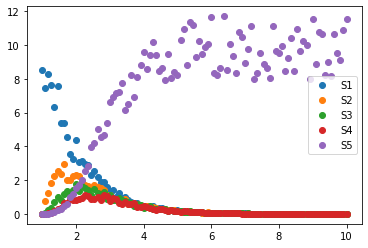

In [4]:
data = NamedTimeseries(csvPath=LINEAR_PATHWAY_DATA)
fig, ax = plt.subplots(1)
for col in data.colnames:
    ax.scatter(data[TIME], data[col])
_ = plt.legend(data.colnames)

## Helper Functions <a class="anchor" id="helper-functions"></a>

In [5]:
def plotTS(ts, title=""):
    """
    Plots columns in a timeseries.
    
    Parameters
    ----------
    ts: NamedTimeseries
    """
    p = plt.plot(ts[TIME], ts[ts.colnames])
    _ = plt.legend(p, ts.colnames, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = plt.title(title)

In [6]:
def makeSyntheticTS(trueTS, proportion):
    """
    Constructs synthetic data in proportion to values of true data.
    
    Parameters
    ----------
    trueTS: NamedTimeseries of true data
    proportion: float indicating the proportional of value to change
    
    Returns
    -------
    NamedTimeseries
    """
    synTS = trueTS.copy()
    for col in synTS.colnames:
        epsilons = np.random.uniform(-1, 1, len(synTS))
        synTS[col] += proportion*synTS[col]*epsilons
    return synTS

The following sections provide details of parameter fitting using the ``PATHWAY_MODEL``.

## Fitting Basics

Some key concepts are:
- A **parameter** is a constant whose value is unknown.
- **Observed data** are data that are used for fitting parameter values.
- **Fitted data** are data produced by a simulation for an assignment of values to parameters.
- **Residuals** are the difference between observed data and simulated data.

The basic algorithm for fitting is described below.
The algorithm estimates ``parameters``, the vector of values of unknown parameters.
The inputs to the algoritm are:
- ``model`` - the simulation model
- ``parameters`` parameters to estimate with their initial values
- ``observedData`` observed data used for fitting

1. **Initialization**
   1. ``fittedData = simulate(model, parameters)``
   1. ``residuals = observedData - fittedData``
1. **Loop**
   1. ``parameters`` = adjust ``parameters`` based on ``residuals``
   1. ``fittedData = simulation(parameters)``
   1. ``residuals = observedData - fittedData``
   1. if ``residuals`` are small
       1. ``return parameters``

The algorithm is fairly straight forward, with one exception.
Step A - "adjust ``parameters`` based on ``residuals``" How are these adjustments made?

The adjustments are made based on an optimization that chooses parameter values that
minimize the residuals.
We give a brief discussion of optimization in the next section.

## Optimization Essentials

Given a function $f(x_1, \cdots, x_n)$, an optimizer finds $(x_1^{\star}, \cdots, x_n^{\star})$
that results in the smallest value of $f(x_1, \cdots, x_n)$.

Sometimes, this search is easy. Consider the curve below.

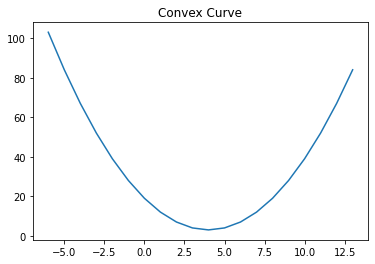

In [7]:
xv = np.array(range(20))
xv = xv - 6
_ = plt.plot(xv, 3 + (xv - 4)**2 )
_ = plt.title("Convex Curve")

We can readily see that the minimum value of this function occurs at $x^{\star} = 4$.
This is an example of a convex curve. A convex curve has the very nice property
that its local minimum is also the global minimum.
That is, there are no small valleys where the optimizer might get "stuck".
For this reason, it's easy to find $x^{\star}$ using gradient decent or
Newton's method.

Unfortunately, convex curves are rare in practice. Much more common is something like the following.

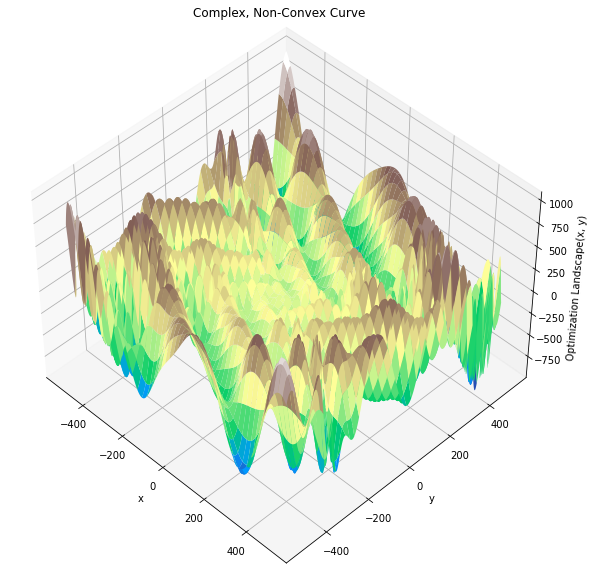

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
          -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Optimization Landscape(x, y)')
ax.set_title("Complex, Non-Convex Curve")
plt.show()

For curves such as these, hueristic methods are needed such as differential evolution, simulated annealing, and random stochastic
gradient descent.

## Fitting With SBstoat

1. Inputs to and running SBstoat
1. Analysis of output
1. Effect of varying columns to fit
1. Effect of wide parameter range

### Running SBstoat

``SBstoat`` is a python package intended to simplify the programmatic aspects of fitting. The package provides handles the programming details
of the interactions between the optimization codes (``lmfit``) and ``tellurium`` simulations.

The required inputs to ``SBstoat`` are:
- the model for which parameter values are being estimated;
- observational data; and
- specification of the parameters, their value ranges, and initial values.

For the linear pathway model, we ``LINEAR_PATHWAY_MODEL`` and ``LINEAR_PATHWAY_DATA`` for the model and data, respectively.
The description of the paarameters is done using a python dictionary, as shown below.

In [9]:
# Name, minimal value, initial value, and maximum value of each parameter
LINEAR_PATHWAY_PARAMETER_DCT = {
    "k1": (1, 50, 100),
    "k2": (1, 50, 100),
    "k3": (1, 50, 100),
    "k4": (1, 50, 100),
    }

In [10]:
fitter = ModelFitter(LINEAR_PATHWAY_MODEL, LINEAR_PATHWAY_DATA, parameterDct=LINEAR_PATHWAY_PARAMETER_DCT)
fitter.fitModel()

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



``SBstoat`` provides a textual report of the results of the fit.

In [11]:
print(fitter.reportFit())

[[Fit Statistics]]
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Variables]]
    k1:  1.01353780 +/- 0.02296852 (2.27%) (init = 49.45837)
    k2:  2.15812893 +/- 0.10237614 (4.74%) (init = 12.11086)
    k3:  3.07934276 +/- 0.21142110 (6.87%) (init = 1.157576)
    k4:  4.28039770 +/- 0.40626621 (9.49%) (init = 16.20033)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


The report is in three sections.

The first section contains measures of the fit quality. The most commonly used measures are chi-square and reduced chai-square.
We want both of these to be "small", although small is relative.
These measures are most useful when comparing different fit results.

The "Variables" section gives parameter estimates. We se that the estimates obtained are fairly close to
the true values in the original models.

The final section provides information about the relationships between parameter estimates. This can be useful
in models where the structure of the model makes it difficult to separate one parameter from another.
In these cases, there will be a large correlation between parameter (absolute) parameter values.

``SBstoat`` provides many plots to aid in understanding the fitting results.
You can see these by typing in a Jupyter code cell ``fitter.pl`` and then pressing the tab key.
Arguably the most useful is ``plotFitAll``, which, for each floating species (column in observed data), plots the fitted and observed values.
This is shown below.

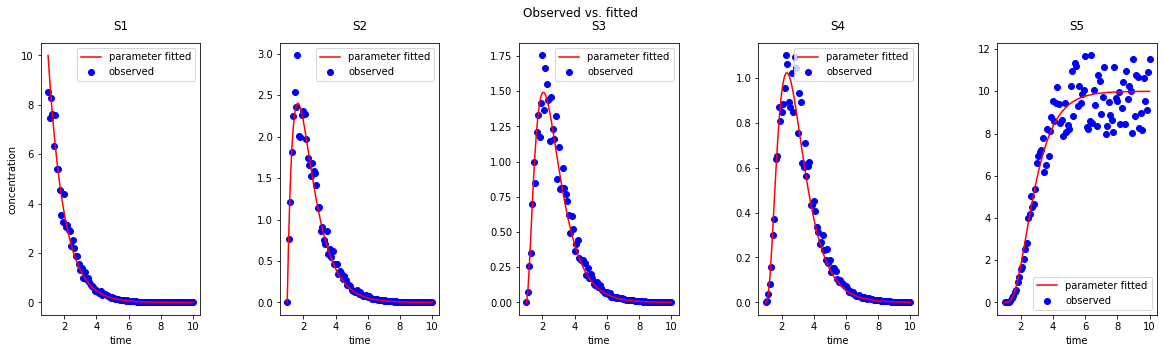

In [12]:
fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

These fits seem to be quite consistent with the observed data, with the possible exception of ``S5``.
In the latter case, there is considerable variability that likely makes a good fit more difficult.

In [13]:
# See the options for plotFitAll
?fitter.plotFitAll

Signature:
fitter.plotFitAll(
    isMultiple=False,
    params:lmfit.parameter.Parameters=None,
    numPoint:int=None,
    **kwargs,
)
Docstring:
Plots the fitted with observed data over time.

Parameters
----------
isMultiple: bool
    plots all variables on a single plot

A figure may contain 1 or more plot, and each plot may contain
1 or more line. Figure (f), plot (p), and line (c) are the possible
scope of an option.  If the option is singled valued, then it applies
to all instances of its scope. If it has multiple values, then the
index of the value corresponds to the instance within the scope.
A figure scope is always single valued.
        color: str
    (l) color of the line
    default = blue
columns: list
    (f) List of columns to plot
    default = []
legend: list
    (f) Tuple of str for legend
linestyle: str
    (l) Line style
marker: str
    (l) Marker for line
markersize: float
    (l) Size of marker for the line; >0
numCol: int
    (f) columns of plots
numRow: int
   

If you are interested in a more complete analysis of the residuals, use ``plotResidualsAll``.

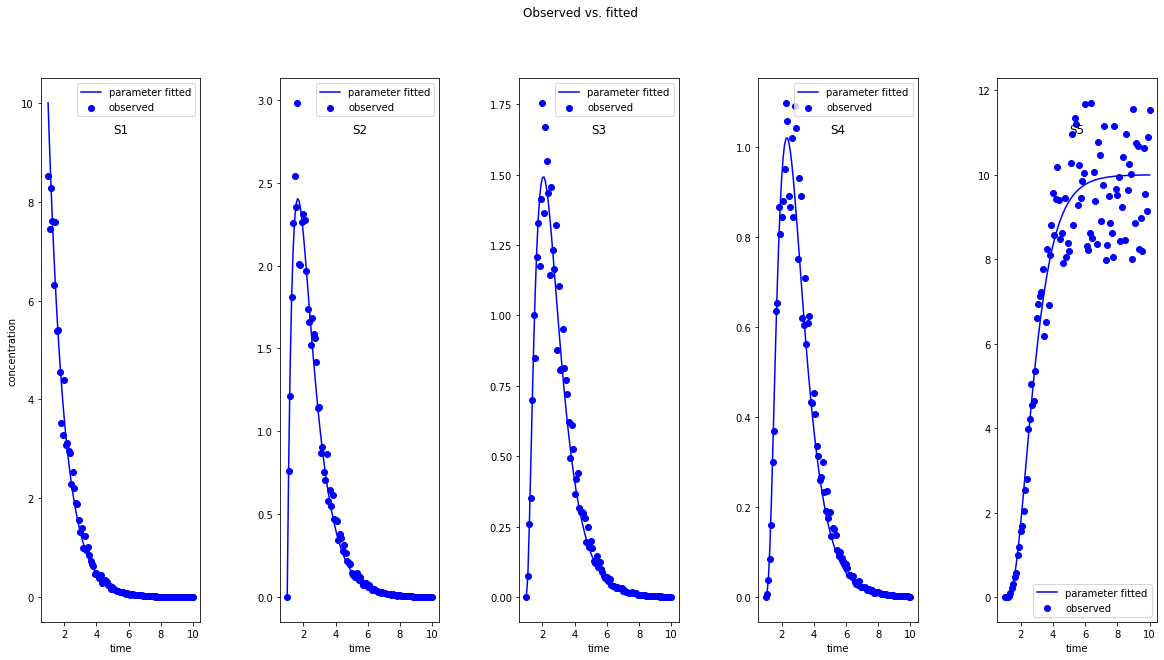

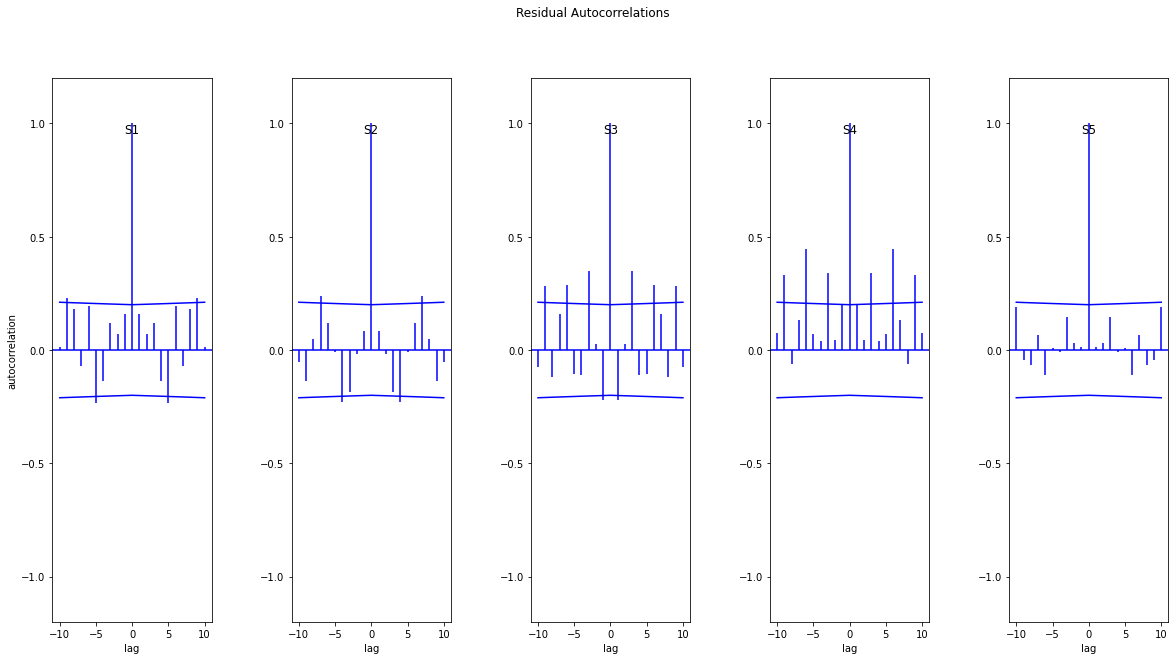

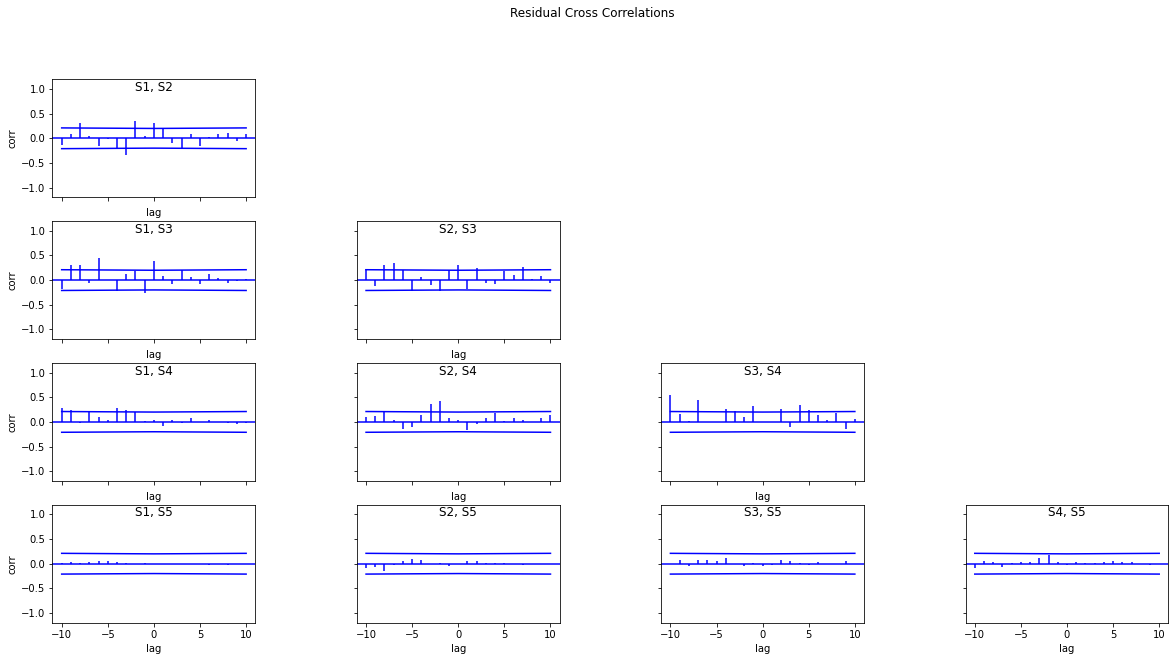

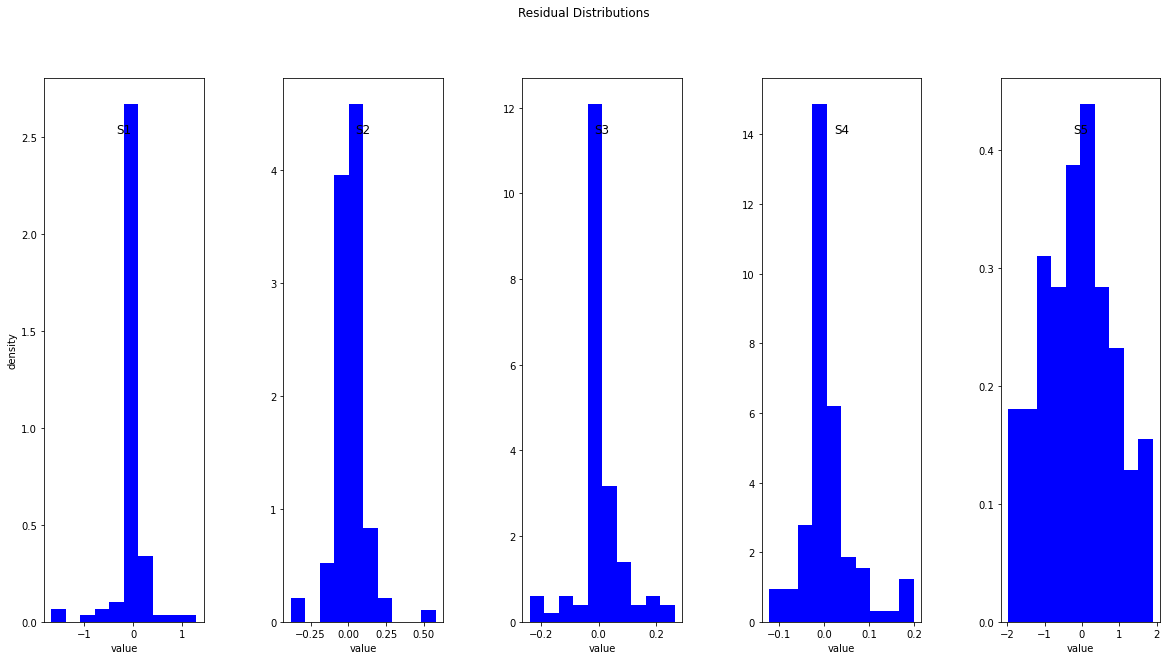

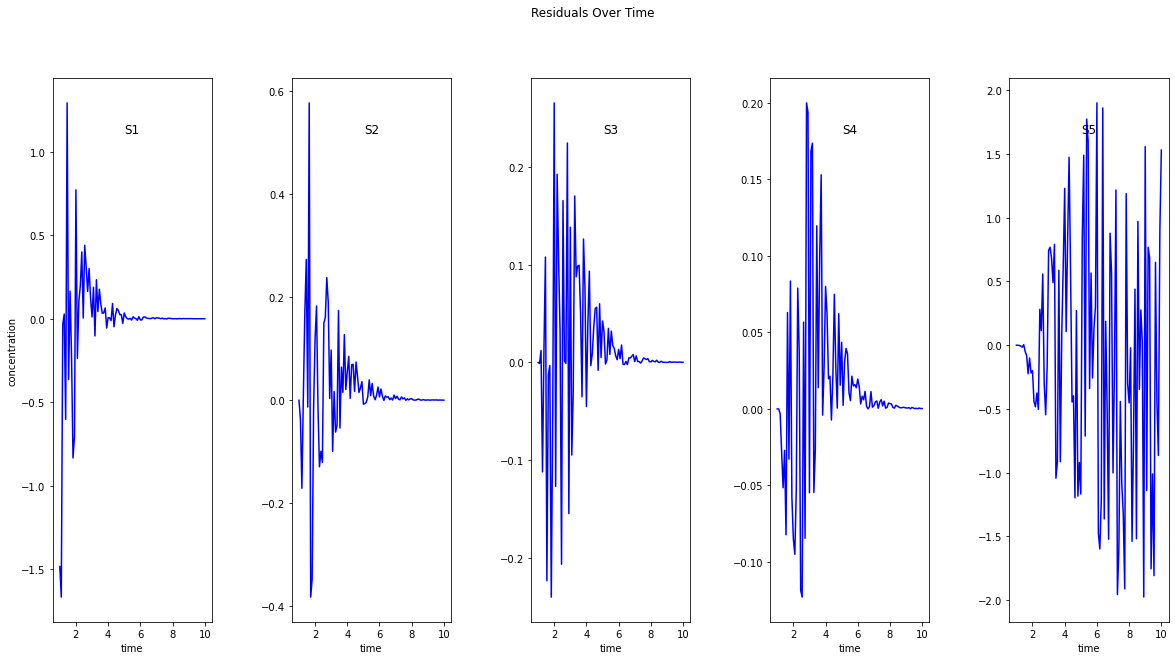

In [14]:
fitter.plotResidualsAll(figsize=(20, 10))

## Exploring the Linear Pathway Model

Although ``SBstoat`` eliminates the burden of programming details, fitting is often complex.
This is because of the complexity of the fitting surface, as illustrated earlier in this chaper.
This section illustrates how to use ``SBstoat`` to explore complex fitting surfaces.

``SBstoat`` allows you to explore fitting along three dimensions.
1. **Fitting surface**. The fitting surface changes based on the following:
  a. the selection of float species (columns in the observed data) that we attempt to fit;
  b. the time span we fit over
1. **Search stategy**. This depends on our choice of optimization algorithm. Beyond this, we may choose to use several optimization
algorithms in sequence. Also, some optimization algorithms are stochastic, and so the search strategy may also choose to run
the same algorithm multiple times.
1. **Search start & scope**. This refers to the initial values of parameter values and the range of parameter values that are explored.


In the following explorations of the above dimensions of parameter fitting, we use the above workflow that consists of:
1. Select a subset of the observed data based on a specified time span (in this case, just ending time)
1. Construct a fitter for the linear pathway, observed data, columns to consider in fitting, the fitting methods, and parameter ranges/initial values.
1. Fit the model.
1. Print the fitting report.
1. Plot observed and fitted values.

This workflow is encapsulated in the the function ``doFit``.
The arguments of the function have default that reproduce the
results in the previous section.

In [15]:
def doFit(selectedColumns=None, endTime=10, fitterMethods=["differential_evolution", "leastsq"], parameterDct=LINEAR_PATHWAY_PARAMETER_DCT):
    model = te.loada(LINEAR_PATHWAY_MODEL)
    observedTS = NamedTimeseries(LINEAR_PATHWAY_DATA)
    # Find the last index to use
    lastIdx = len([t for t in observedTS[TIME] if t <= endTime])
    observedTS = observedTS[:lastIdx]
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, observedTS, selectedColumns=selectedColumns, fitterMethods=fitterMethods, parameterDct=parameterDct)
    fitter.fitModel()
    print(fitter.reportFit())
    fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],  titlePosition=(0.5, 1.05))

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Variables]]
    k1:  1.01353779 +/- 0.02296911 (2.27%) (init = 15.58201)
    k2:  2.15812905 +/- 0.10237624 (4.74%) (init = 48.99171)
    k3:  3.07934026 +/- 0.21142127 (6.87%) (init = 1.020692)
    k4:  4.28040126 +/- 0.40626757 (9.49%) (init = 3.351525)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


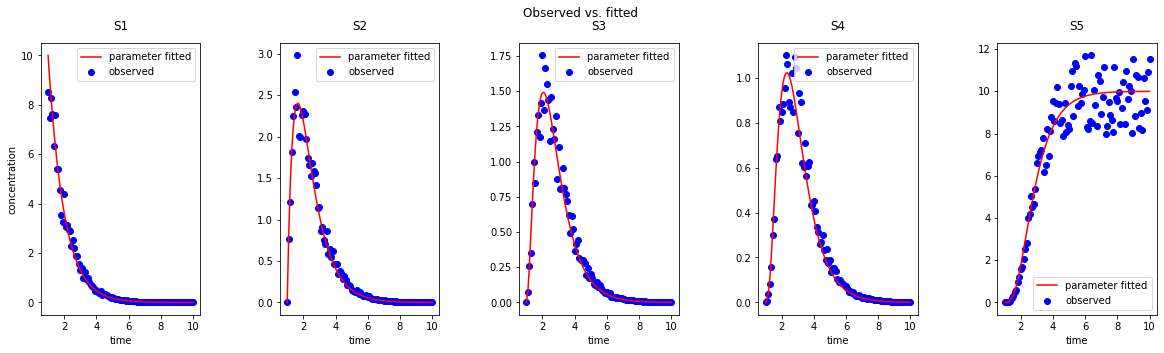

In [16]:
doFit()

### Fitting Surface

We begin by exploring the effect of the fitting surface. Suppose that we only consider ``S5`` and so the fitting surface is residuals
from fitting ``S5``.

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 90.7507758
    reduced chi-square = 0.94532058
    Akaike info crit   = -1.70531638
    Bayesian info crit = 8.71536436
[[Variables]]
    k1:  2.85281112 +/- 5669.31908 (198727.46%) (init = 2.988527)
    k2:  2.85234021 +/- 1065021.47 (37338514.91%) (init = 46.97868)
    k3:  1.07385415 +/- 0.63650291 (59.27%) (init = 24.3139)
    k4:  2.85237640 +/- 1062928.84 (37264676.59%) (init = 10.44721)
[[Correlations]] (unreported correlations are < 0.100)
    C(k2, k4) = -1.000
    C(k1, k3) = -0.868
    C(k1, k2) = -0.374
    C(k1, k4) =  0.369


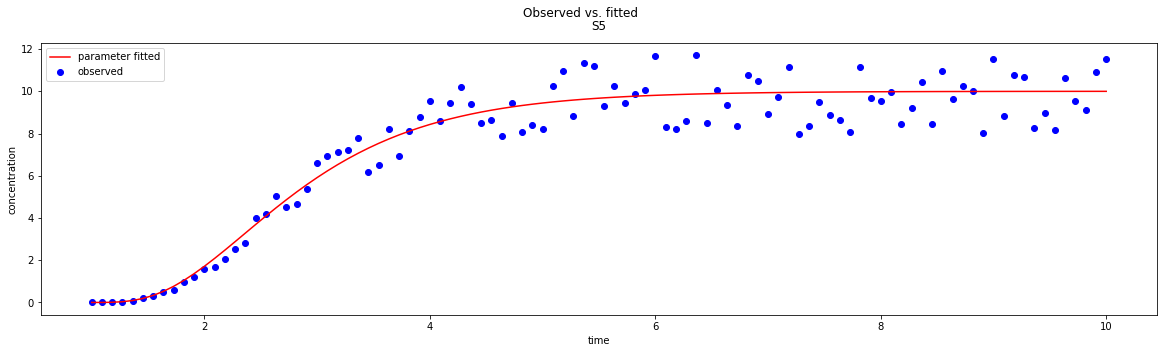

In [17]:
doFit(selectedColumns=["S5"])

We see that the fitted line does not match well the dynamics in the observed data. Another observation is that the chi-square increased
by a factor of 10.
In general, we recommend that all floating species be used.

Another consideration is to focus on a subset of the dynamics. Below, we only consider through 6 seconds.

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (6.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 6.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 43.1151131
    reduced chi-square = 0.15621418
    Akaike info crit   = -515.856484
    Bayesian info crit = -501.317326
[[Variables]]
    k1:  1.02434441 +/- 0.02033387 (1.99%) (init = 49.26582)
    k2:  2.16006261 +/- 0.08871312 (4.11%) (init = 44.76901)
    k3:  3.07390231 +/- 0.18232153 (5.93%) (init = 24.96401)
    k4:  4.26054334 +/- 0.34848952 (8.18%) (init = 24.76967)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.242
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.183


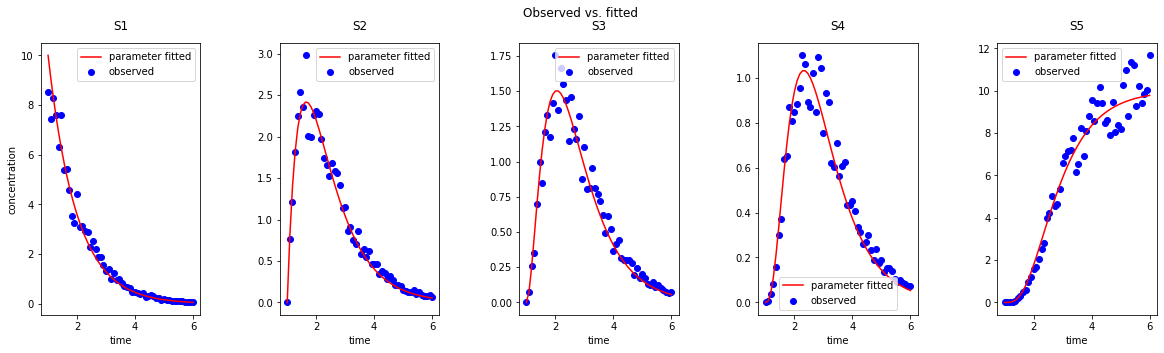

In [18]:
doFit(endTime=6)

This improved the quality of the fit. We see this visually in the above plots and also in the significant reduction in chi-square. A lot of this improvement
is a result of not inluding regions of high variability in observed values for ``S5``.

### Search Strategy

The main consideration here is the choice of optimization algorithms.
Any valid ``method`` for ``lmfit`` can be used, and multiple methods can be used in combination. We illustrate this below.

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Variables]]
    k1:  1.01353731 +/- 0.02298640 (2.27%) (init = 50)
    k2:  2.15812980 +/- 0.10237743 (4.74%) (init = 50)
    k3:  3.07933965 +/- 0.21142433 (6.87%) (init = 50)
    k4:  4.28040340 +/- 0.40626628 (9.49%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


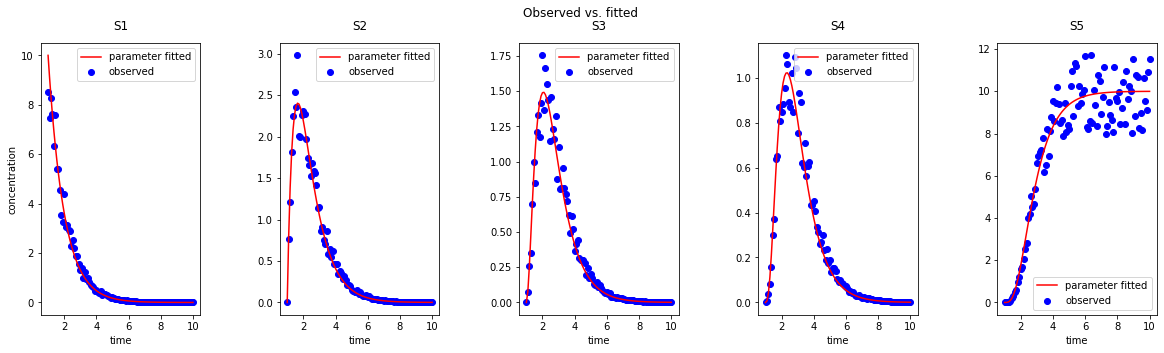

In [19]:
# Fit with Levenberg-Marquardt 
doFit(fitterMethods=["leastsq"])

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 1922.53601
    reduced chi-square = 3.87608067
    Akaike info crit   = 681.396168
    Bayesian info crit = 698.254600
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    k1:  21.1034334 (init = 50)
    k2:  19.1293826 (init = 50)
    k3:  8.03334831 (init = 50)
    k4:  49.9996134 (init = 50)


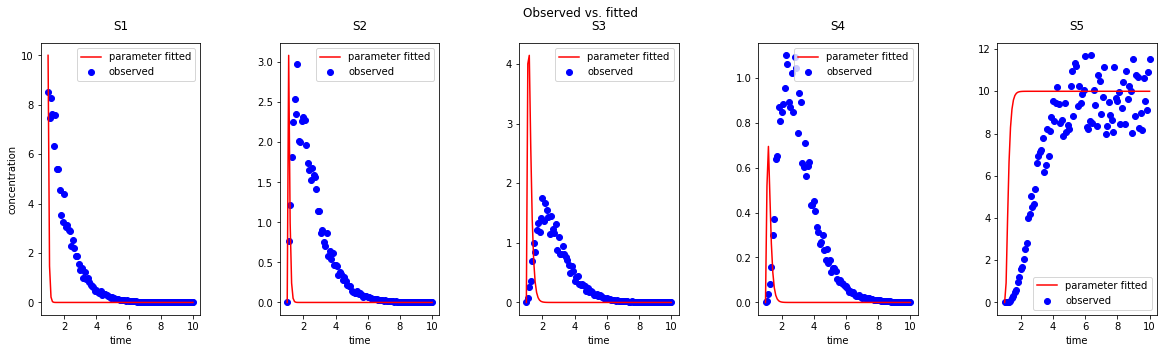

In [20]:
# Fit with differential evolution
doFit(fitterMethods=["differential_evolution"])

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(1.0, 10.0, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 102.939841
    reduced chi-square = 0.20754000
    Akaike info crit   = -782.231674
    Bayesian info crit = -765.373241
[[Variables]]
    k1:  1.01353671 +/- 0.02302009 (2.27%) (init = 6.69964)
    k2:  2.15813458 +/- 0.10237345 (4.74%) (init = 47.92125)
    k3:  3.07933252 +/- 0.21145288 (6.87%) (init = 19.36586)
    k4:  4.28038618 +/- 0.40634261 (9.49%) (init = 27.14414)
[[Correlations]] (unreported correlations are < 0.100)
    C(k3, k4) = -0.297
    C(k2, k3) = -0.263
    C(k2, k4) = -0.243
    C(k1, k2) = -0.227
    C(k1, k3) = -0.188
    C(k1, k4) = -0.182


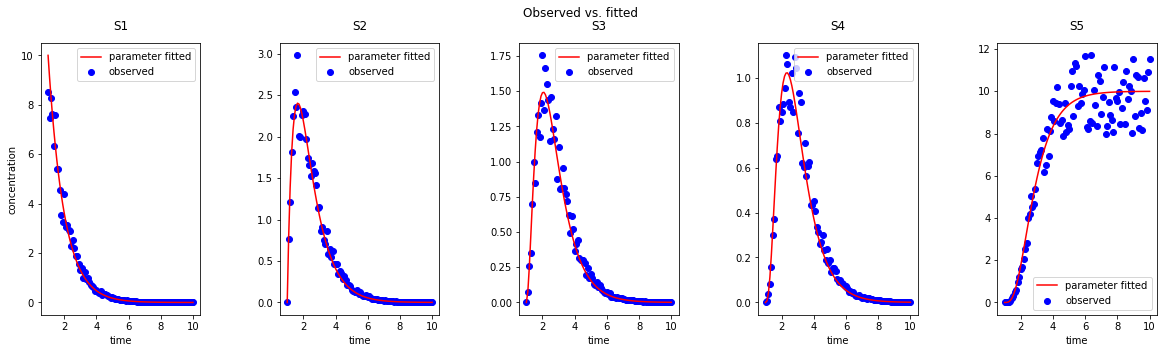

In [21]:
# Fit with differential evolution and then Levenberg-Marquardt 
doFit(fitterMethods=["differential_evolution", "leastsq"])

For this model, we see that Levenberg-Marquardt works better than differential evolution, and doing the two in combination offers no benefit.

### Search Start & Scope

Where we start the search and how far we search depends on the ranges of parameter values and the specification of initial values.
This is specified by the ``parameterDct`` argument to ``ModelFitter``. This argument defaults to ``LINEAR_PATHWAY_PARAMETER_DCT``.

In [36]:
# Dictionary values are: lower end of parameter range, initial parameter value, upper end of parameter range
LINEAR_PATHWAY_PARAMETER_DCT

{'k1': 1.0, 'k2': 2.0, 'k3': 3.0, 'k4': 4.0}

If we create a bad parameter range, then we get very poor fits. Below, we start the search with a negative value for each parameter.
Note that the observed values appear to be constant because of the large scale of the fitted values.

[[Fit Statistics]]
    chi-square         = 8.9214e+81
    reduced chi-square = 1.7987e+79
    Akaike info crit   = 91249.6186
    Bayesian info crit = 91266.4771
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    k1: -2.24820615 (init = -1)
    k2: -7.85742179 (init = -1)
    k3: -1.95100022 (init = -1)
    k4: -10.3572521 (init = -1)


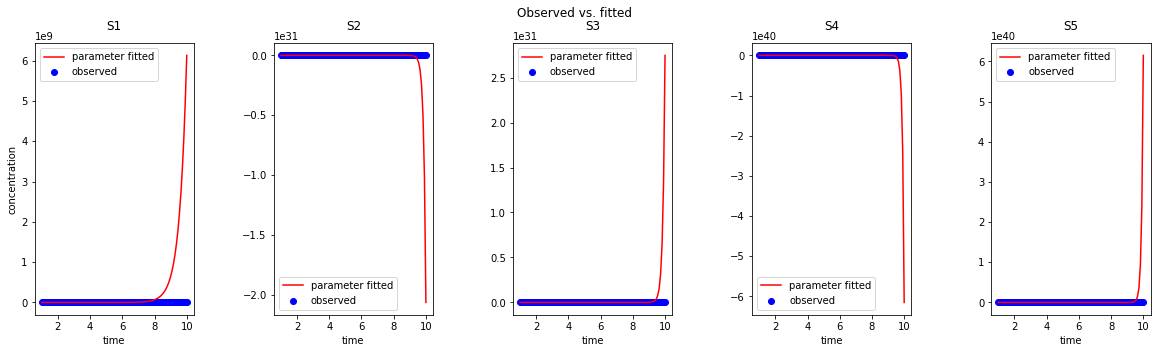

In [35]:
parameterDct = {
 'k1': (-11, -1, 100),
 'k2': (-11, -1, 100),
 'k3': (-11, -1, 100),
 'k4': (-11, -1, 100)}
doFit(parameterDct=parameterDct)

## Fitting for Glycolytic Oscillations

1. Do fit for first 50 (1s) and just J9_k and columns Glucose and Pyruvate
1. Point out challenges with other parameters
1. Story
   a. See effect of algorithm. LSQ alone works better than DE
   a. Choice of columns?
   b. Try fitting all parameters, all times. Works poorly because high frequency -> high variance
   c. Adjust parameter ranges and starting point.
   d. Allow algorithm to run for more iterations.
   e. Repeat method using numFitRepeat option

In [24]:
WOLF_PARAMETER_DCT = {
      "J1_n": (1, 8, 8),  # 4
      "J9_k": (1, 50, 50),   # 28
    }

/home/ubuntu/reproducible-biomodel-case-study/rcs/lib/python3.6/site-packages/roadrunner/roadrunner.py:3944: UserWarning:

Simulation requested end point (1.9939879759519037) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. r.simulate(0.0, 1.9939879759519037, 1001)
  * Setting r.integrator.variable_step_size to 'False'
* Setting 



[[Fit Statistics]]
    chi-square         = 854.986851
    reduced chi-square = 0.38898401
    Akaike info crit   = -2075.27841
    Bayesian info crit = -2063.88598
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    J1_n:  3.99899450 (init = 8)
    J9_k:  28.0315280 (init = 50)


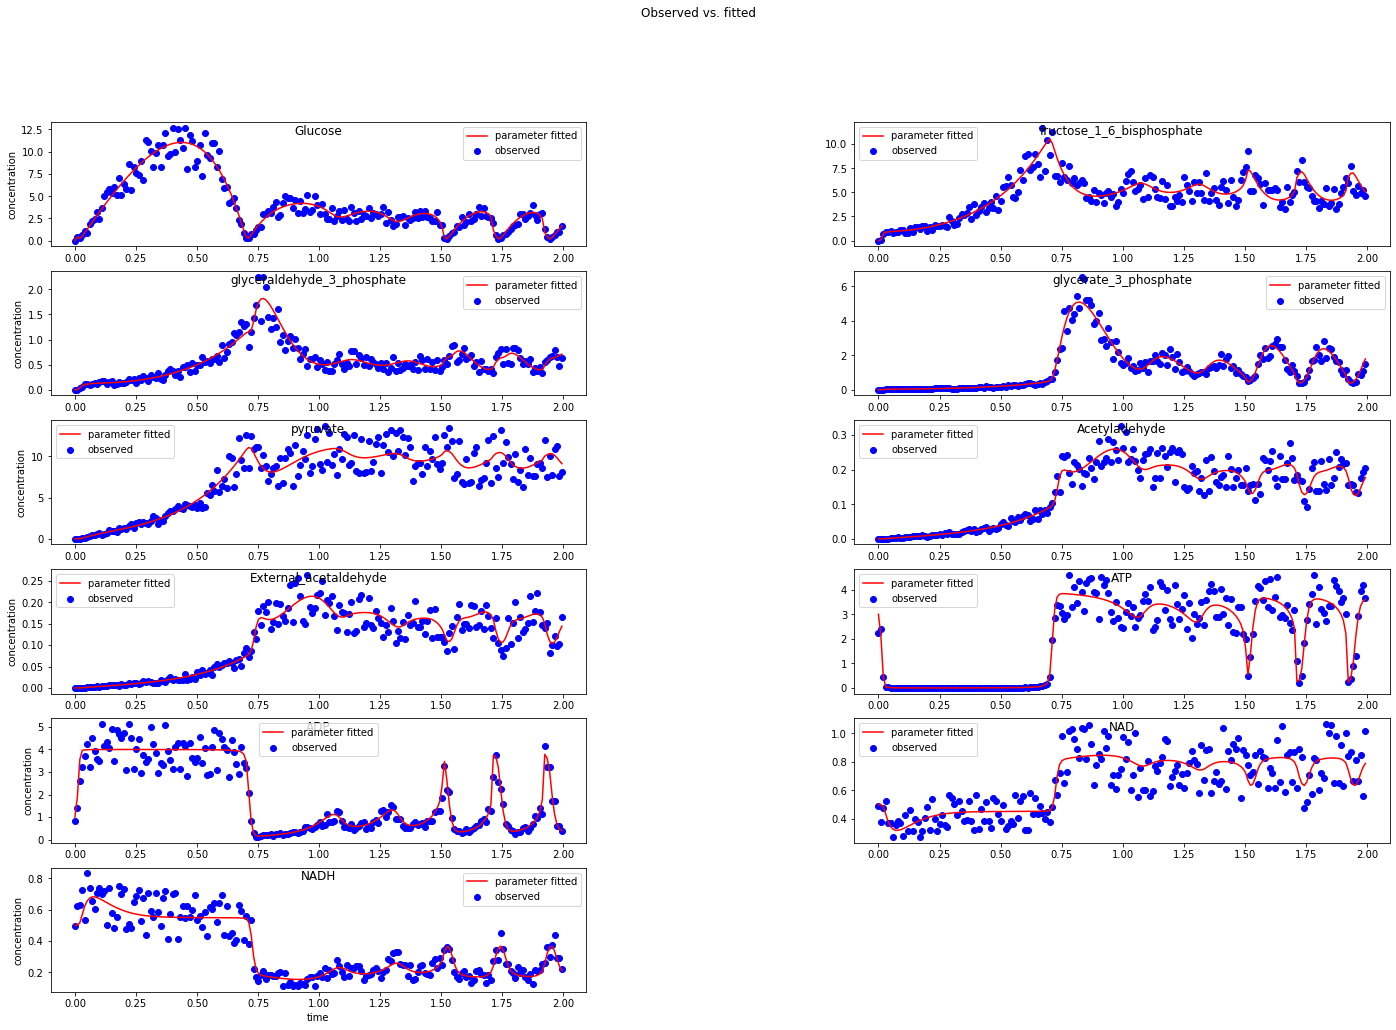

In [25]:
# WHY DOES REPORT SAY DE?
wolfModel = te.loada(WOLF_MODEL)
ts = NamedTimeseries(WOLF_DATA)
newTS = ts[0:200]
fitter = ModelFitter(wolfModel, newTS, parameterDct=WOLF_PARAMETER_DCT, fitterMethods=["differential_evolution", "leastsq"],
                    numFitRepeat=1)
fitter.fitModel(max_nfev=None)
print(fitter.reportFit())
fitter.plotFitAll(figsize=(24,16), numCol=2, color=["red", "blue"])

## Estimating Parameter Variances With Bootstrapping

## Tips for Fitting

There is considerable art in fitting. The quality of parameter fits
can be improved by exploring the following:
- **What you fit**. This means, which species concentrations you include in the residuals, what part of the time course
you try to fit, and the ranges you choose for parameter values.
- **How you fit**.
  - Choice of algorithm
  - Choice of time range
- **How much compute**. Fitting is computationally intensive. More compute time is often needed for a better result. ``SBstoat`` helps
in this regard by making use of multiple cores. Number of iterations (max_fev).

## Appendix 1 - Synthetic Observational Data for Linear Pathway
This appendix describes how data was generated to create synthetic observations for the linear pathway example.

The first step is to generate data for the "ground truth" model.

In [26]:
# Constants used in this Appendix
LINEAR_PATHWAY_PARAMETER_DCT = {
    "k1": 1.0,
    "k2": 2.0,
    "k3": 3.0,
    "k4": 4.0,
}
LINEAR_PATHWAY_PROPORTION = 0.2

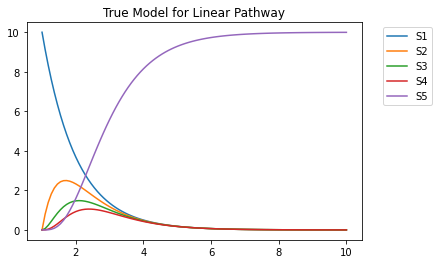

In [27]:
rr = te.loada(LINEAR_PATHWAY_MODEL)
for parameter in LINEAR_PATHWAY_PARAMETER_DCT.keys():
    rr[parameter] = LINEAR_PATHWAY_PARAMETER_DCT[parameter]
trueTS = NamedTimeseries(namedArray=rr.simulate(1, 10, 100))
plotTS(trueTS, title="True Model for Linear Pathway")

Next, we convert the output data, a numpy named array, into a ``NamedTimeseries``, a data structure that is well suited for
time series manipulations.

In [28]:
syntheticTS = makeSyntheticTS(trueTS, LINEAR_PATHWAY_PROPORTION)

Now, we add some random noise. For this example, we add normally distributed random variables with a mean of 0
and a standard deviation of 0.2.

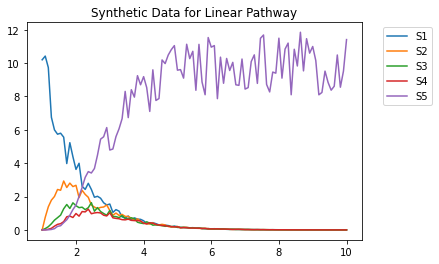

In [29]:
plotTS(syntheticTS, title="Synthetic Data for Linear Pathway")

Last, we write the result to a file.

In [30]:
#syntheticTS.to_csv(LINEAR_PATHWAY_DATA)

## Appendix 2 - Synthetic Observational Data for Glycolytic Oscilations

In [31]:
# Constants used in this Appendix
WOLF_PROPORTION = 0.3

This appendix describes how data was generated to create synthetic observations for the Wolf
glycolytic oscillations model.

We see that in this mode there is a large variation in the scale of the values of the time series.

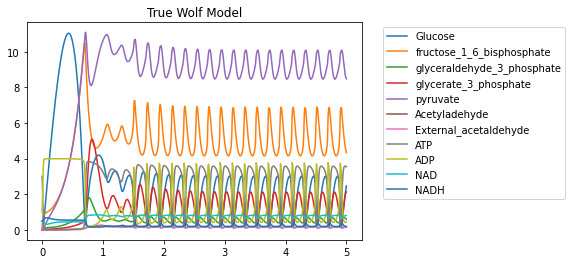

In [32]:
rr = te.loada(WOLF_MODEL)
trueTS = NamedTimeseries(namedArray=rr.simulate(0, ENDTIME, NUMPOINT))
plotTS(trueTS, "True Wolf Model")

So, constructing meaningful synthetic observed data requires some thought.

Our approach is to use a *proportional error model*.
That is, the variability we introduced, which is referred to as *error* in statistics, depends on the true value.
Let $x$ be the true value of the variable, $p$ be the proportion for which we introduce "error",
and $\epsilon$ be a random number chosen uniformly from $[-1, 1]$.
Then, the synthetic observed values is $x (1 +  p \epsilon)$.

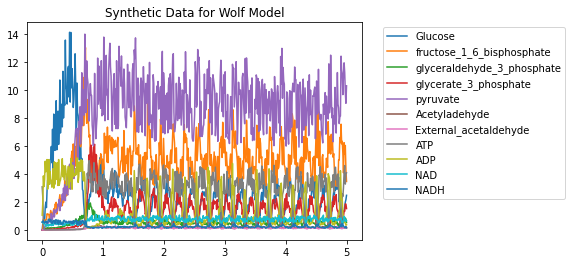

In [33]:
syntheticTS = makeSyntheticTS(trueTS, WOLF_PROPORTION)
plotTS(syntheticTS, title = "Synthetic Data for Wolf Model")

In [34]:
#syntheticTS.to_csv(WOLF_DATA)